## Import libraries

In [20]:
# Import libaries
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import os 
import time
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Image

## Import data

**Images of train set are shuffled! So we need to allocate them in train set and valid set.But first we define new paths including original train set and test set**

In [2]:
origin_path = './data/train_origin'
train_path = './data/train'
valid_path = './data/valid'
test_path = './data/test'

**Create folders for cats train , dogs train , cats validation and dogs validation.**
**Use *os* library to make new directories**

In [3]:
labels = ['dogs', 'cats']

for label in labels:
    os.makedirs(train_path + '/' + label)
    os.makedirs(valid_path + '/' + label)

**Next we need to allocate images of cat into cats train , cats validation and the same for dogs. Firstly, we define a valid_ratio = 0.25 (cretare 25% data for validation)**

In [6]:
valid_ratio = 0.25

**Below we define :**
- *os.listdir(origin_path)* : to walk through all images in original train set
- *dst* : a path to guide image where it should locate
- *numpy.random.random()* : return a real number in range(0,1) . It controls to which set an image should belong
- *src* : a full path of image
- *shutil.copyfile(src,dts)* : this method consist of 2 arguments. It guides *scr* into *dst*

In [7]:
for path in os.listdir(origin_path):
    dst = train_path
    if np.random.random() < valid_ratio:
        dst = valid_path
    if path.startswith("cat"):
        src = origin_path + '/' + path
        dst = dst + '/' + 'cats'+ '/' + path
        shutil.copyfile(src, dst)
    else:
        src = origin_path + '/' + path
        dst = dst + '/' + 'dogs'+ '/' + path
        shutil.copyfile(src, dst)

**It maybe take a while. When done, take a look folders and count image number to make sure everything goes correctly!**

In [12]:
print('number of cat images for training:', len(os.listdir('./data/train\\cats')))
print('number of dog images for training:', len(os.listdir('./data/train\\dogs')))
print('number of cat images for validation:', len(os.listdir('./data/valid\\cats')))
print('number of dog images for validation:', len(os.listdir('./data/valid\\dogs')))

number of cat images for training: 9372
number of dog images for training: 9387
number of cat images for validation: 3128
number of dog images for validation: 3113


## Prepare data

The steps involving preparing these images are:
* Read images from the disk
* Decode contents of these images and convert it into proper grid format as per their RGB content
* Convert them into floating point tensors
* Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

**we set up a image data transformer to cover bad circumstances (that means we generate a not so clean new data). Here we use ImageDataGenerator from tensorflow library.It consists a lot of preprocessing method like rotation, height shift , width shift , shearing transformation , flipping . . .**

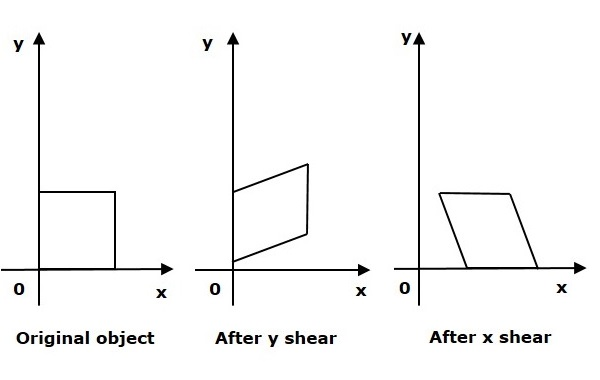

In [24]:
display(Image("shearing.jpg"))

In [26]:
train_generator = ImageDataGenerator(
        rotation_range=40, #range within which to randomly rotate pictures
        width_shift_range=0.2, #randomly translate pictures vertically
        height_shift_range=0.2, #horizontally,
        rescale=1./255,
        shear_range=0.2, #randomly applying shearing transformations
        zoom_range=0.2, #randomly zooming inside pictures
        horizontal_flip=True, #randomly flipping half of the images horizontally
        fill_mode='nearest') 

valid_generator = ImageDataGenerator(rescale = 1./255)

In [27]:
batch_size = 64
epoch = 10
image_size = 200

#this is augmentation for training data
train_gen = train_generator.flow_from_directory(directory=train_path, 
                                        batch_size=batch_size, 
                                        shuffle=True,
                                        target_size=(image_size, image_size),
                                        class_mode='binary',
                                        seed = 101)

#
valid_gen = valid_generator.flow_from_directory(directory=valid_path,
                                               batch_size = batch_size,
                                              target_size=(image_size, image_size),
                                              class_mode='binary')

Found 18759 images belonging to 2 classes.
Found 6241 images belonging to 2 classes.


## Define a baseline model

A simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. <br>
This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

In [24]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(200,200,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [26]:
model = define_model()

checkpoint = ModelCheckpoint("first_baseline.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [28]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 64)       

In [35]:
epochs = 5
train_steps = train_gen.n // train_gen.batch_size
valid_steps = valid_gen.n // valid_gen.batch_size

history = model.fit(train_gen,
          steps_per_epoch = train_steps,
          epochs=epochs,
          verbose=1,
          validation_data= valid_gen,
          validation_steps = valid_steps,
          callbacks=[checkpoint])

Epoch 1/5
 97/293 [========>.....................] - ETA: 2:16 - loss: 0.6215 - acc: 0.6490
Epoch 00001: loss improved from inf to 0.67839, saving model to first_baseline.hdf5
293/293 [==============================] - 477s 2s/step - loss: 0.6784 - acc: 0.5776 - val_loss: 0.6215 - val_acc: 0.6490
Epoch 2/5
 97/293 [========>.....................] - ETA: 2:16 - loss: 0.5631 - acc: 0.7044
Epoch 00002: loss improved from 0.67839 to 0.62520, saving model to first_baseline.hdf5
293/293 [==============================] - 464s 2s/step - loss: 0.6252 - acc: 0.6529 - val_loss: 0.5631 - val_acc: 0.7044
Epoch 3/5
 97/293 [========>.....................] - ETA: 2:13 - loss: 0.5325 - acc: 0.7255
Epoch 00003: loss improved from 0.62520 to 0.59194, saving model to first_baseline.hdf5
293/293 [==============================] - 463s 2s/step - loss: 0.5918 - acc: 0.6925 - val_loss: 0.5325 - val_acc: 0.7255
Epoch 4/5
 97/293 [========>.....................] - ETA: 2:10 - loss: 0.5150 - acc: 0.7416
Epoch 

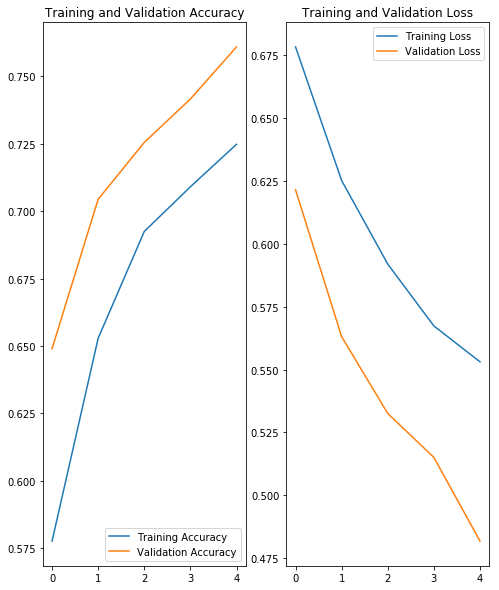

In [38]:
##visualize the result
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

See ! Baseline model give a quite low accuracy . Now we fly to the next one !

## Introduction to concept Transfer learning

- **Deep networks give good results but training time is too long (maybe last to 2-3 weeks)**
- **When encounter a new data , rarely do people retrain . This is because there are not too much big-size data source.Instead , people take advantage of pre-trained model which is modified something to solve individual problems.This technique is called TRANSFER LEARNING**
- **Base on an assumption that all images share some commons , people can use Feature Extractor of pre-trained model**

* We will use the VGG16 architecture, pre-trained on the ImageNet dataset 
    * instantiate the convolutional base of VGG16 and load its weights
    * add our previously defined fully-connected model on top, and load its weights
    * freeze the layers of the VGG16 model up to the last convolutional block

### Initialize with VGG16 model

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(200, 200, 3))
vgg_model.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Combine another model and modify optimizer

In [12]:
model = tf.keras.Sequential([
    vgg_model,
    GlobalAveragePooling2D(),
    Dense(1, activation = 'sigmoid')])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Setup epoch , step per epoch , checkpoint

In [ ]:
epochs = 5
train_steps = train_gen.n // train_gen.batch_size
valid_steps = valid_gen.n // valid_gen.batch_size

checkpoint = ModelCheckpoint("vgg_model.ckpt", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(train_gen,
          steps_per_epoch = train_steps,
          epochs=epochs,
          verbose=1,
          validation_data= valid_gen,
          validation_steps = valid_steps,
          callbacks=[checkpoint])

Epoch 1/5
 97/293 [========>.....................] - ETA: 2:24 - loss: 0.4650 - acc: 0.8400
Epoch 00001: loss improved from inf to 0.59064, saving model to vgg_model.ckpt
293/293 [==============================] - 484s 2s/step - loss: 0.5906 - acc: 0.7388 - val_loss: 0.4650 - val_acc: 0.8400
Epoch 2/5
 97/293 [========>.....................] - ETA: 2:24 - loss: 0.3863 - acc: 0.8611
Epoch 00002: loss improved from 0.59064 to 0.48274, saving model to vgg_model.ckpt
293/293 [==============================] - 480s 2s/step - loss: 0.4828 - acc: 0.8090 - val_loss: 0.3863 - val_acc: 0.8611
Epoch 3/5
 97/293 [========>.....................] - ETA: 2:30 - loss: 0.3422 - acc: 0.8719
Epoch 00003: loss improved from 0.48274 to 0.43371, saving model to vgg_model.ckpt
293/293 [==============================] - 492s 2s/step - loss: 0.4336 - acc: 0.8289 - val_loss: 0.3422 - val_acc: 0.8719
Epoch 4/5
 97/293 [========>.....................] - ETA: 2:31 - loss: 0.3238 - acc: 0.8747
Epoch 00004: loss imp

In [15]:
model.save('model_vgg.h5')

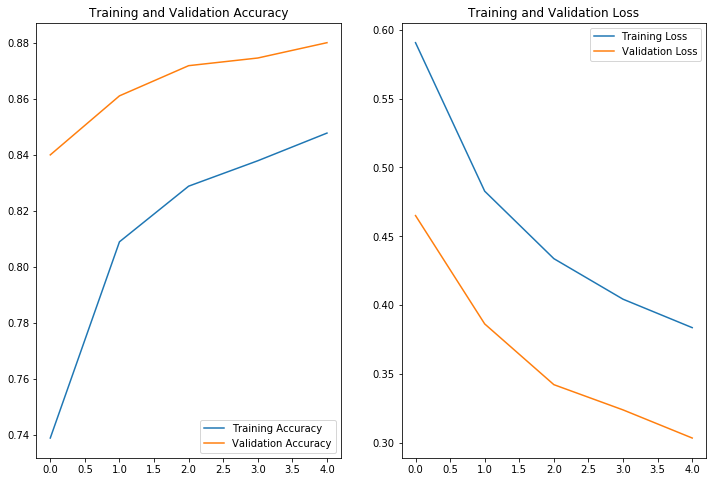

In [17]:
##visualize the result
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('model_vgg.h5')

epochs = 5
train_steps = train_gen.n // train_gen.batch_size
valid_steps = valid_gen.n // valid_gen.batch_size
history = new_model.fit(train_gen,
          steps_per_epoch = train_steps,
          epochs=epochs,
          verbose=1,
          validation_data= valid_gen,
          validation_steps = valid_steps)

Epoch 1/5
293/293 [==============================] - 500s 2s/step - loss: 0.3672 - acc: 0.8517 - val_loss: 0.2878 - val_acc: 0.8884
Epoch 2/5
293/293 [==============================] - 486s 2s/step - loss: 0.3552 - acc: 0.8556 - val_loss: 0.2859 - val_acc: 0.8848
Epoch 3/5
293/293 [==============================] - 459s 2s/step - loss: 0.3459 - acc: 0.8601 - val_loss: 0.2680 - val_acc: 0.8943
Epoch 4/5
293/293 [==============================] - 447s 2s/step - loss: 0.3369 - acc: 0.8636 - val_loss: 0.2705 - val_acc: 0.8909
Epoch 5/5
  7/293 [..............................] - ETA: 3:51 - loss: 0.2618 - acc: 0.8951